## Melio Data Classifiability Assignment


In [268]:
import os
import random

import pandas as pd
import numpy as np

from scipy.stats import f_oneway
import matplotlib.pyplot as plt

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns

### 1) Loading and Preprocessing the data


In [269]:
# Path to the directory containing CSV files
data_path = './data/melt-csv-sample' 
file_names = [f for f in os.listdir(data_path) if f.endswith('.csv')]
print("File names found:", file_names)

dataframes = [pd.read_csv(os.path.join(data_path, file)) for file in file_names]

for i, df in enumerate(dataframes):
    print(f"Class {i+1} shape: {df.shape}")

File names found: ['E0AP4Q_C49A_WellDetails.csv', 'E0AGDE_C18A_WellDetails.csv', 'E0A9Y6_C15B_WellDetails.csv', 'E0BFFI_C46A_WellDetails.csv', 'E0ALTB_C10A_WellDetails.csv']
Class 1 shape: (500, 2202)
Class 2 shape: (500, 802)
Class 3 shape: (500, 1586)
Class 4 shape: (500, 1002)
Class 5 shape: (500, 1202)


In [270]:
# check for missing values and drop columns with no values at all
for df in dataframes:
    if df.isnull().values.any():
        print("Missing values found in DataFrame. Dropping columns with all NaN values.")
        df.dropna(axis=1, how='all', inplace=True)
    else:
        print("No missing values found in DataFrame.")

print("\n")
# check for missing values in each DataFrame
for i, df in enumerate(dataframes):
    missing_values = df.isnull().sum()
    if missing_values.any():
        print(f"Class {i+1} has missing values:")
        print(missing_values[missing_values > 0])
    else:
        print(f"Class {i+1} has no missing values.")

print("\n")
for i, df in enumerate(dataframes):
    print(f"Class {i+1} shape: {df.shape}")

Missing values found in DataFrame. Dropping columns with all NaN values.
Missing values found in DataFrame. Dropping columns with all NaN values.
Missing values found in DataFrame. Dropping columns with all NaN values.
Missing values found in DataFrame. Dropping columns with all NaN values.
Missing values found in DataFrame. Dropping columns with all NaN values.


Class 1 has no missing values.
Class 2 has no missing values.
Class 3 has no missing values.
Class 4 has no missing values.
Class 5 has no missing values.


Class 1 shape: (500, 1013)
Class 2 shape: (500, 801)
Class 3 shape: (500, 1585)
Class 4 shape: (500, 1001)
Class 5 shape: (500, 1001)


In [271]:
# check for unique column names in each DataFrame
for i, df in enumerate(dataframes):
    unique_cols = df.columns.nunique()
    total_cols = len(df.columns)
    if unique_cols < total_cols:
        print(f"Class {i+1} has duplicate column names.")
    else:
        print(f"Class {i+1} has all unique column names.")

Class 1 has all unique column names.
Class 2 has all unique column names.
Class 3 has all unique column names.
Class 4 has all unique column names.
Class 5 has all unique column names.


In [272]:
# Change column series to row series for downstream processing
for i, df in enumerate(dataframes):
    dataframes[i] = df.T
    dataframes[i].columns = dataframes[i].iloc[0]     # Set the first row as the header
    dataframes[i] = dataframes[i][1:]                 # Drop the first row from data

print("\n")
for i, df in enumerate(dataframes):
    print(f"Class {i+1} shape: {df.shape}")



Class 1 shape: (1012, 500)
Class 2 shape: (800, 500)
Class 3 shape: (1584, 500)
Class 4 shape: (1000, 500)
Class 5 shape: (1000, 500)


### 2) EDA and Visualization


In [273]:
class_names = []
for df in dataframes:
    class_name = df.columns.name
    if class_name is not None:
        class_names.append(class_name)
    else:
        class_names.append("Unnamed Class")

# Print class names
print("\nClass names:", class_names)

# Print unique class names
unique_class_names = set(class_names)
print("\nUnique class names:", unique_class_names)


Class names: ['250328_E0ALTB_C10A_6e4_Classifiability-S-pneumoniae-2_0', '250331_E0AGDE_C18A_6e3_Classifiability-Linearity-Abaumannii-cplx-Apittii_0', '250331_E0A9Y6_C15B_6e4_Classifiability-Haemophilus-influenzae_0', '250328_E0ALTB_C10A_6e4_Classifiability-S-pneumoniae-2_0', '250328_E0ALTB_C10A_6e4_Classifiability-S-pneumoniae-2_0']

Unique class names: {'250331_E0AGDE_C18A_6e3_Classifiability-Linearity-Abaumannii-cplx-Apittii_0', '250331_E0A9Y6_C15B_6e4_Classifiability-Haemophilus-influenzae_0', '250328_E0ALTB_C10A_6e4_Classifiability-S-pneumoniae-2_0'}


#### Do three classes denote the same disease i.e S-pneumoniae-2_0?


Class 1


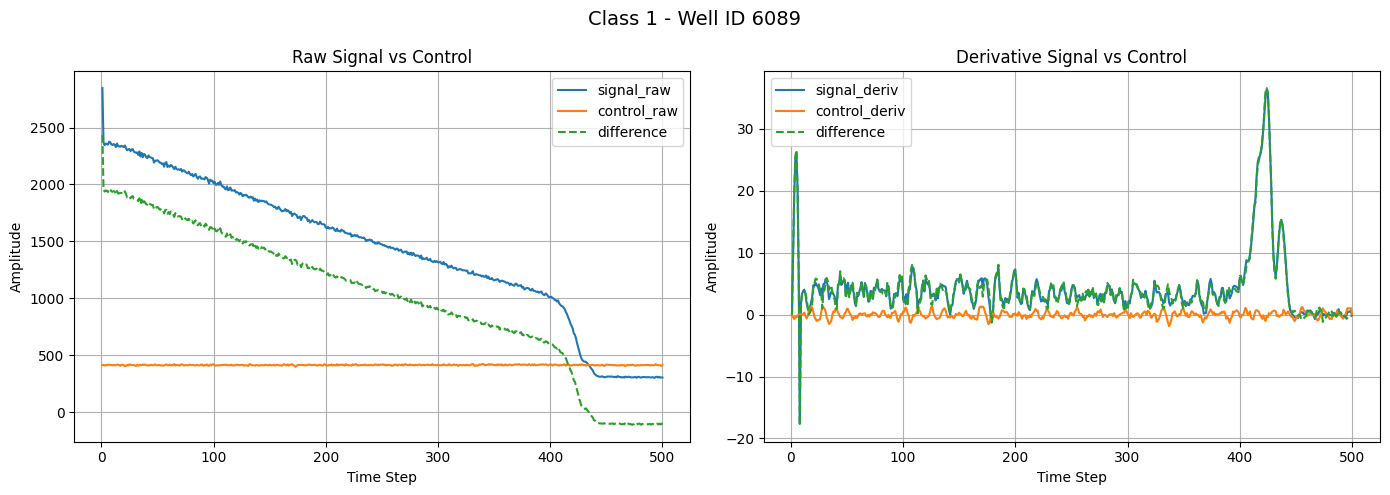

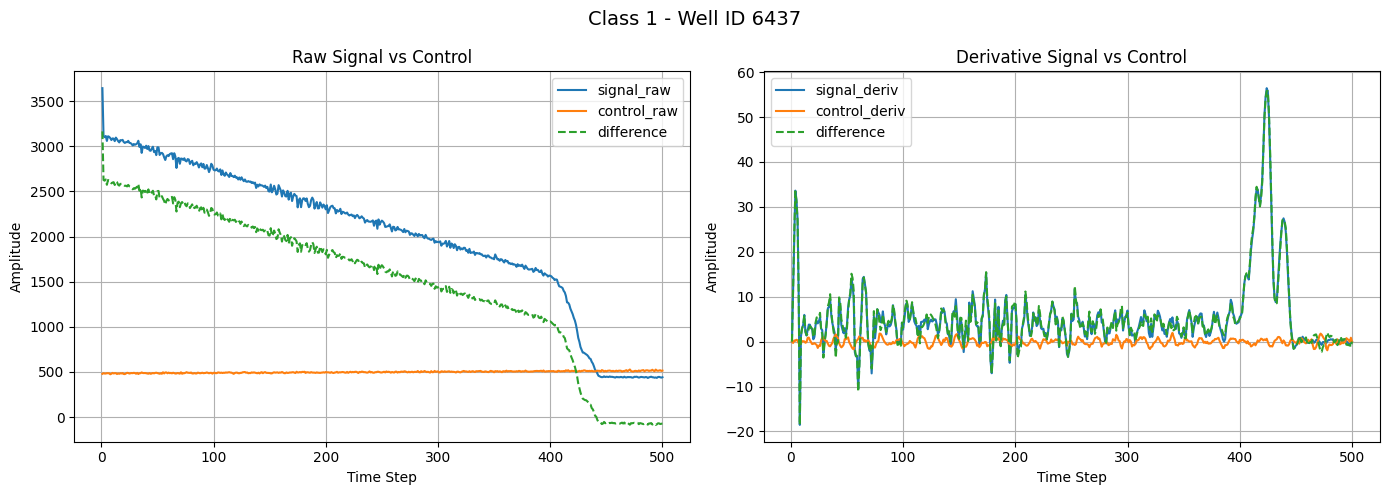

Class 2


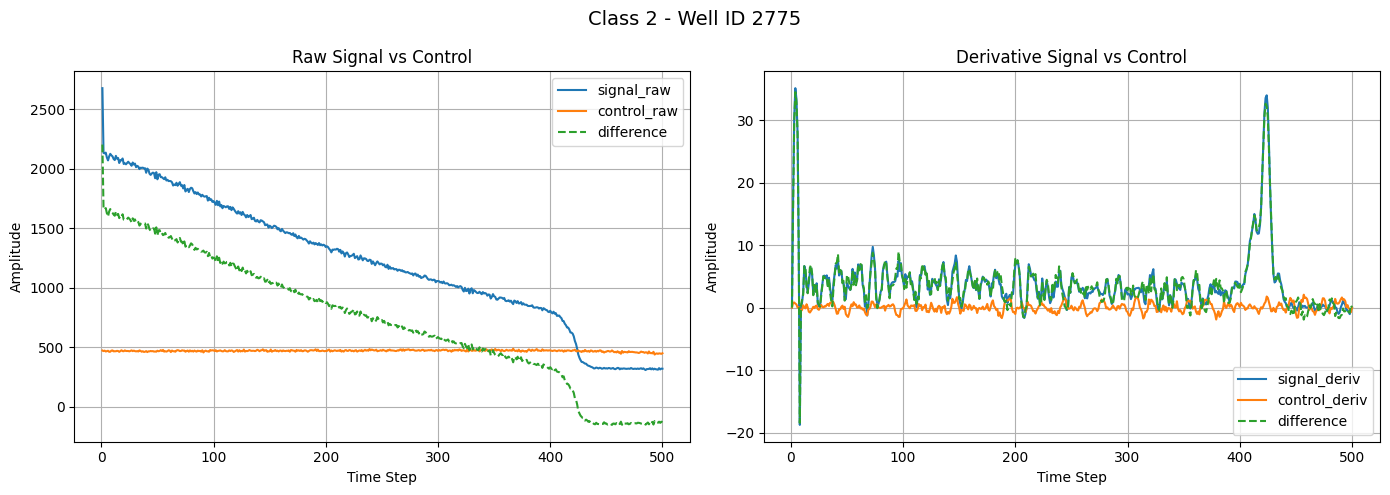

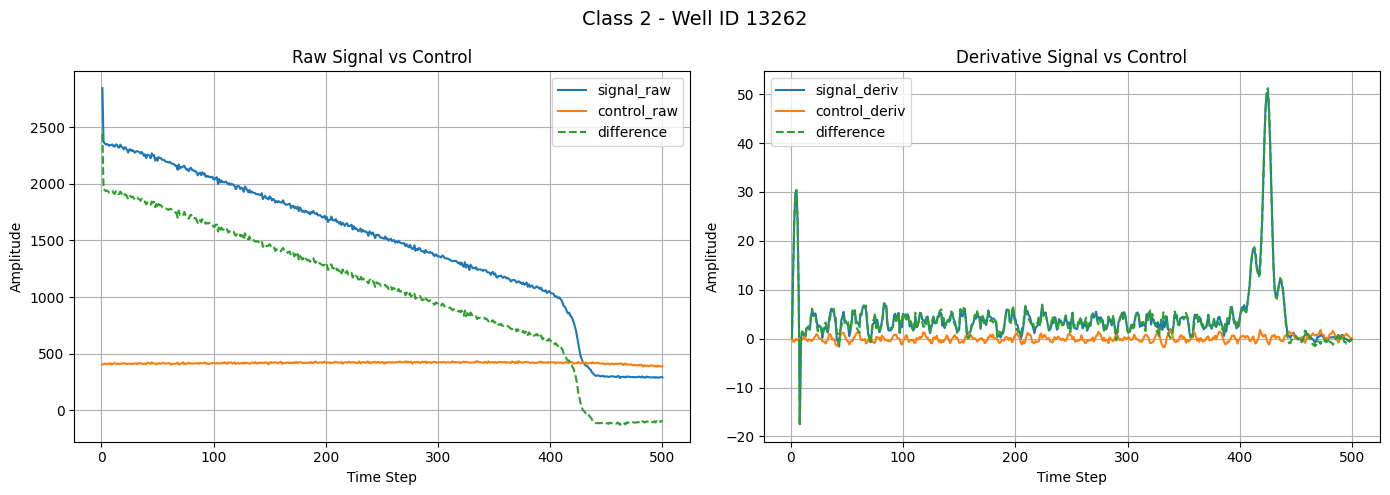

Class 3


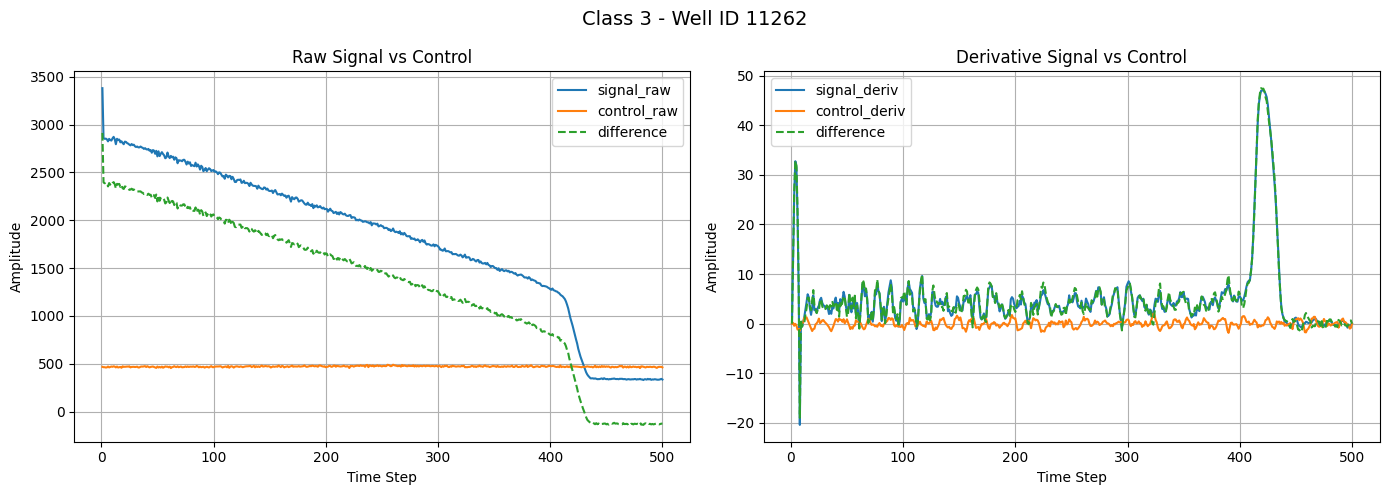

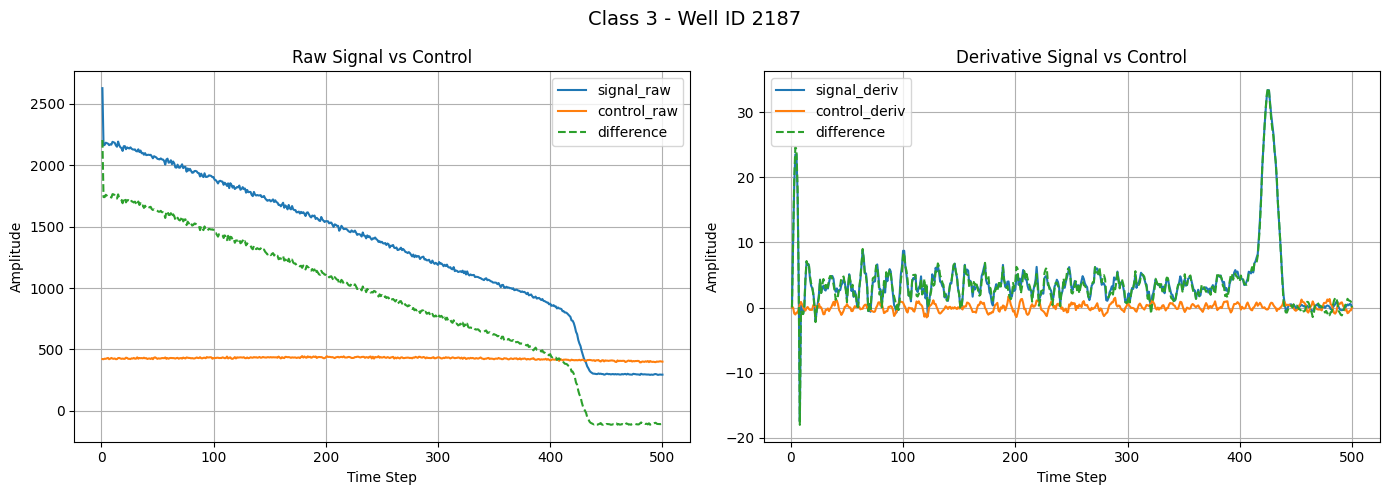

Class 4


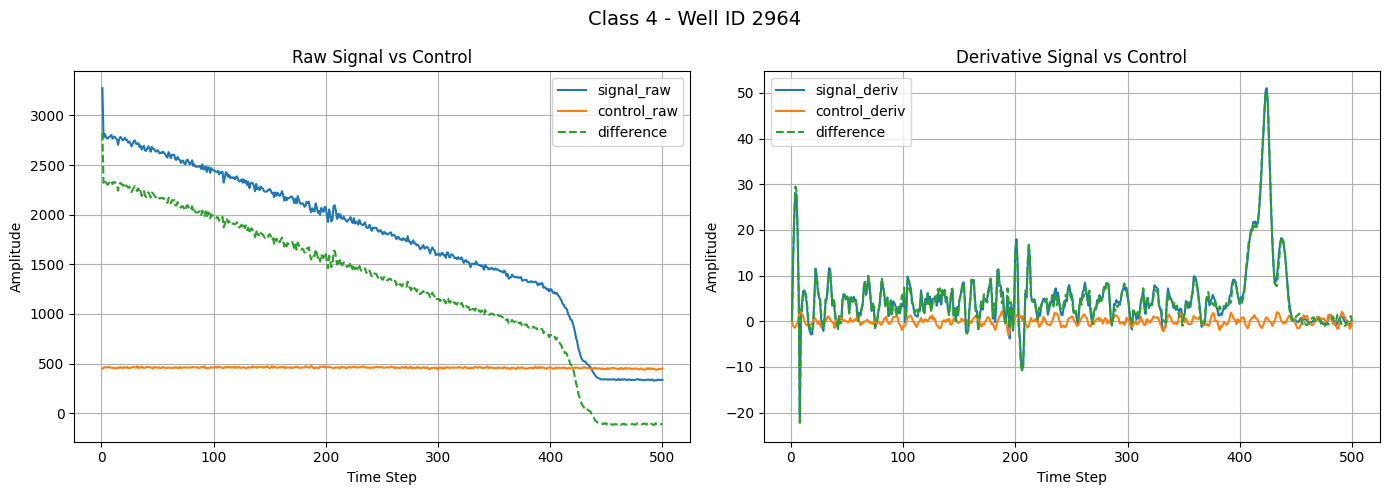

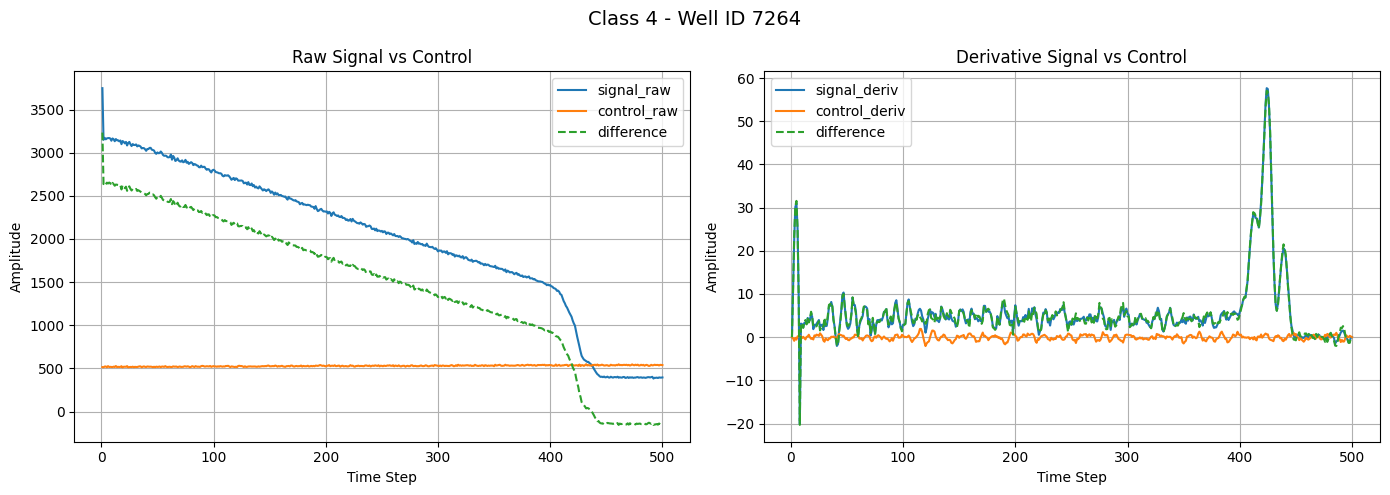

Class 5


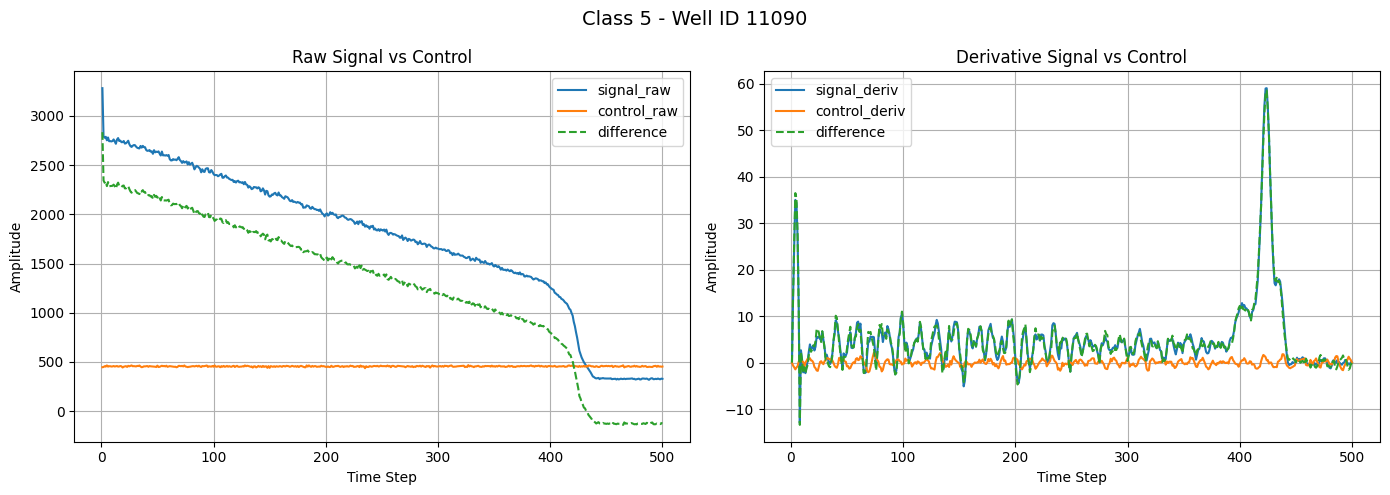

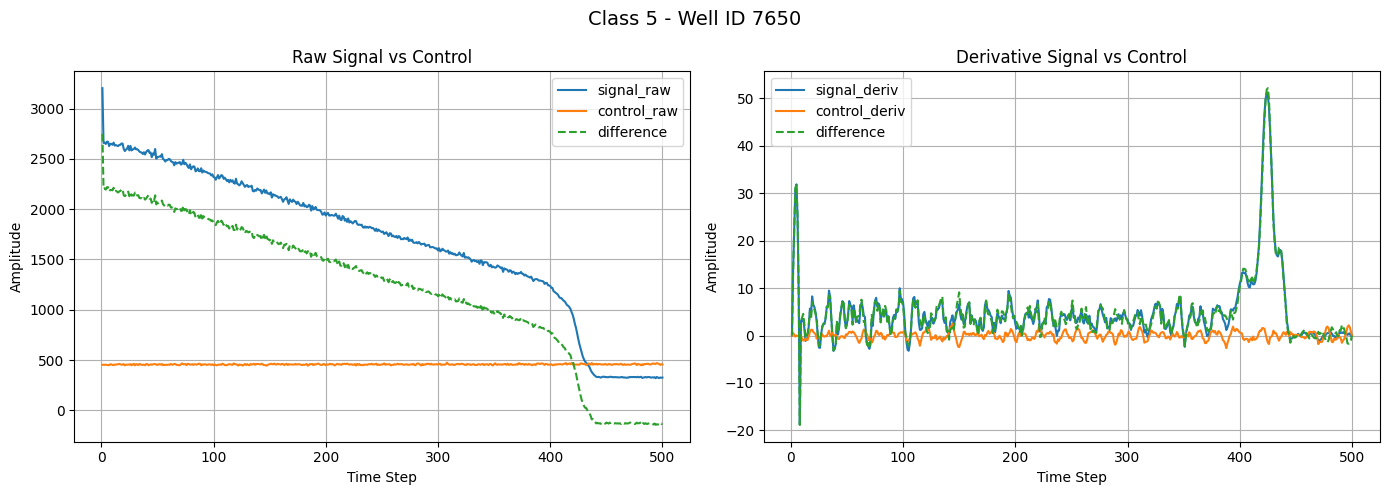

In [274]:
# Inspecting the difference between raw vs control signals
random.seed(42)  # For reproducibility

for class_idx, df in enumerate(dataframes):
    print(f"Class {class_idx + 1}")

    well_ids = set()
    for idx in df.index: 
        if 'signal_raw' in idx: 
            well_id = idx.split('_')[-1]
            if f'control_raw_tseries_Well_Id_{well_id}' in df.index:
                well_ids.add(well_id)
    
    if not well_ids:
        print("No matched signal/control wells found.")
        continue

    sampled_wells = random.sample(list(well_ids), min(2, len(well_ids)))

    for well_id in sampled_wells:
        # Build the index names
        sig_raw = f'signal_raw_tseries_Well_Id_{well_id}'
        ctrl_raw = f'control_raw_tseries_Well_Id_{well_id}'
        sig_deriv = f'signal_deriv_tseries_Well_Id_{well_id}'
        ctrl_deriv = f'control_deriv_tseries_Well_Id_{well_id}'

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Class {class_idx + 1} - Well ID {well_id}', fontsize=14)

        # Plot raw signals
        if sig_raw in df.index and ctrl_raw in df.index:
            s_raw = df.loc[sig_raw]
            c_raw = df.loc[ctrl_raw]
            axes[0].plot(s_raw, label='signal_raw')
            axes[0].plot(c_raw, label='control_raw')
            axes[0].plot(s_raw - c_raw, label='difference', linestyle='--')
            axes[0].set_title("Raw Signal vs Control")
            axes[0].set_xlabel("Time Step")
            axes[0].set_ylabel("Amplitude")
            axes[0].legend()
            axes[0].grid(True)

        # Plot derivatives
        if sig_deriv in df.index and ctrl_deriv in df.index:
            s_deriv = df.loc[sig_deriv]
            c_deriv = df.loc[ctrl_deriv]
            axes[1].plot(s_deriv, label='signal_deriv')
            axes[1].plot(c_deriv, label='control_deriv')
            axes[1].plot(s_deriv - c_deriv, label='difference', linestyle='--')
            axes[1].set_title("Derivative Signal vs Control")
            axes[1].set_xlabel("Time Step")
            axes[1].set_ylabel("Amplitude")
            axes[1].legend()
            axes[1].grid(True)

        plt.tight_layout()
        plt.show()



#### Control signal are consistently flat across all classes and wells, which means they act as static baseline or background nose measurements and don't contribute discriminative information across classes. Hence, not useful as standalone features and can be ignored.


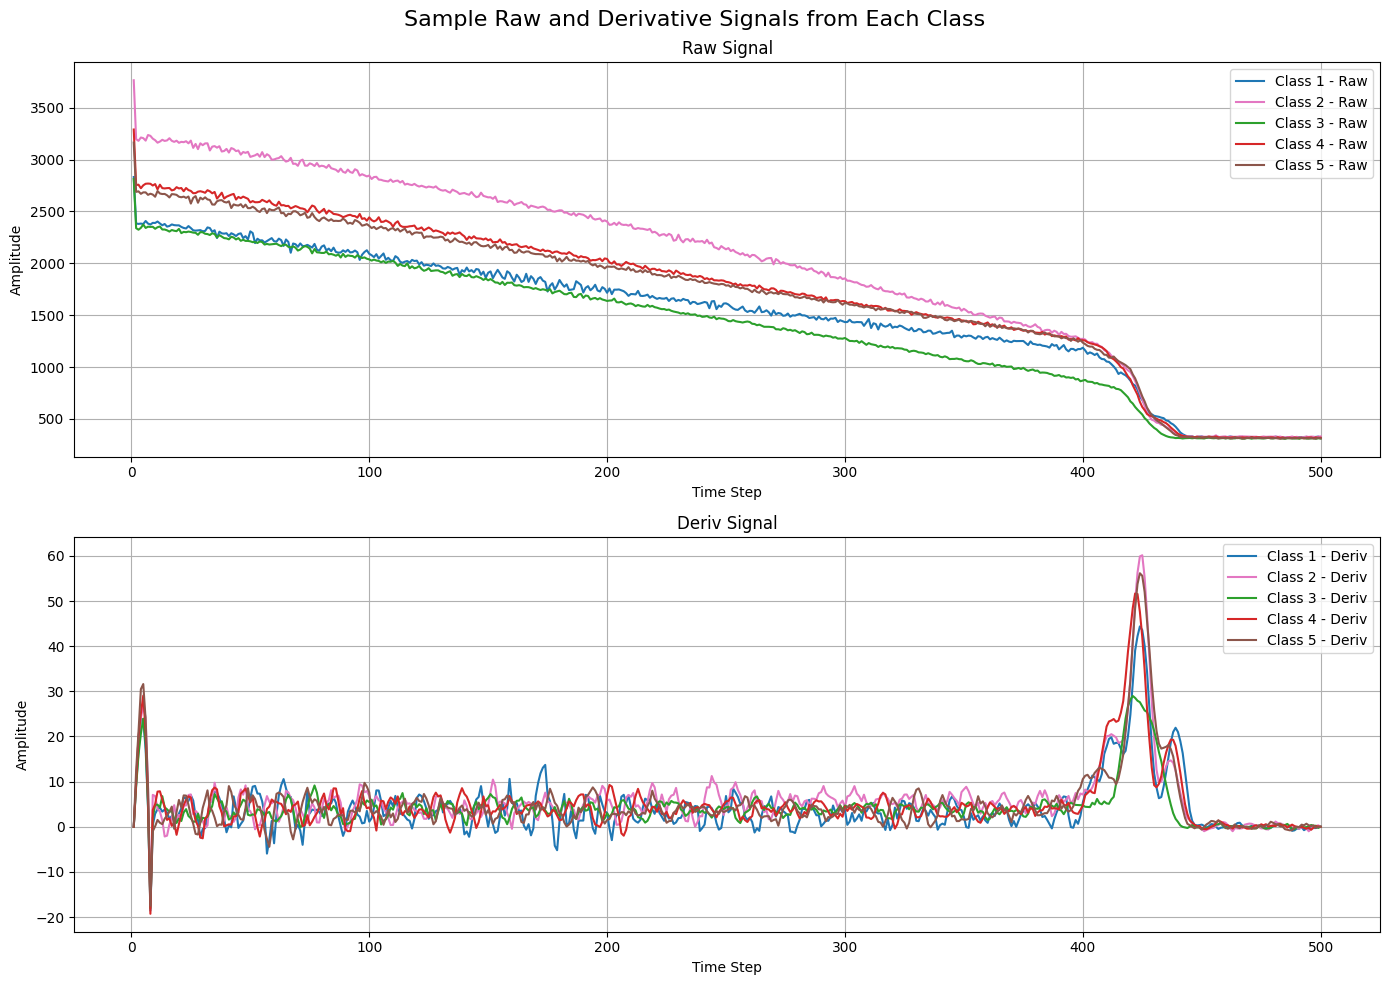

In [275]:
# Plotting the data for each class
random.seed(42)  # For reproducibility

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Sample Raw and Derivative Signals from Each Class', fontsize=16)
axes[0].set_title("Raw Signal Samples")
axes[1].set_title("Derivative Signal Samples")

colors = ['tab:blue', 'tab:pink', 'tab:green', 'tab:red', 'tab:brown']

# Randomly select 2 sample IDs from each DataFrame for plotting, one with signal_raw and one with signal_deriv in the index name
for i, df in enumerate(dataframes):
    signal_raw_indices = df.index[df.index.str.contains('signal_raw')].tolist()

    if signal_raw_indices:
        signal_raw_id = random.sample(signal_raw_indices, 1)[0]
    
    signal_deriv_id = f'signal_deriv_tseries_Well_Id_' + signal_raw_id.split('_')[-1]

    if signal_raw_id in df.index:
        axes[0].plot(df.loc[signal_raw_id], label=f'Class {i+1} - Raw', linestyle='-', color=colors[i])
        axes[0].set_title("Raw Signal")
        axes[0].set_xlabel("Time Step")
        axes[0].set_ylabel("Amplitude")
        axes[0].legend()
        axes[0].grid(True)

    if signal_deriv_id in df.index:
        axes[1].plot(df.loc[signal_deriv_id], label=f'Class {i+1} - Deriv', linestyle='-', color=colors[i])
        axes[1].set_title("Deriv Signal")
        axes[1].set_xlabel("Time Step")
        axes[1].set_ylabel("Amplitude")
        axes[1].legend()
        axes[1].grid(True)

plt.tight_layout()
plt.show()

#### No visible differentiation between classes except for subtle amplitude differences of each signal, especially at timesteps 0-15 and 380-460. Let's verify if this is true for mean signals.


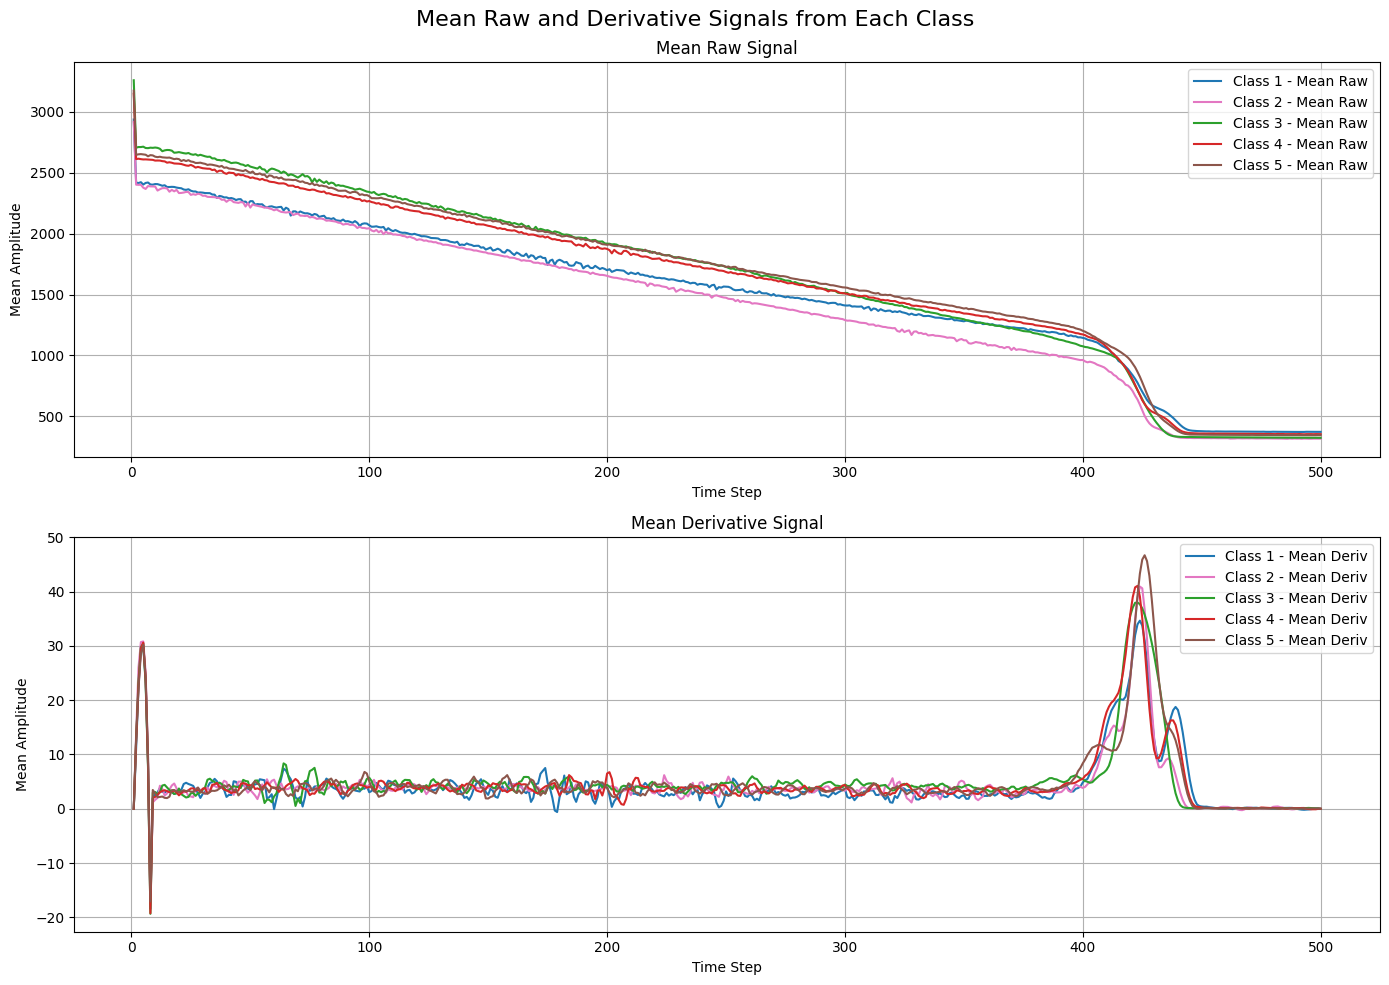

In [276]:
# Check the diffrence between mean signals

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle('Mean Raw and Derivative Signals from Each Class', fontsize=16)
axes[0].set_title("Mean Raw Signal")
axes[1].set_title("Mean Derivative Signal")

for class_idx, df in enumerate(dataframes):
    signal_raw_indices = df.index[df.index.str.contains('signal_raw')].tolist()
    signal_deriv_indices = df.index[df.index.str.contains('signal_deriv')].tolist()

    if signal_raw_indices:
        mean_raw = df.loc[signal_raw_indices].mean(axis=0)
        axes[0].plot(mean_raw, label=f'Class {class_idx+1} - Mean Raw', linestyle='-', color=colors[class_idx])
        axes[0].set_xlabel("Time Step")
        axes[0].set_ylabel("Mean Amplitude")
        axes[0].legend()
        axes[0].grid(True)

    if signal_deriv_indices:
        mean_deriv = df.loc[signal_deriv_indices].mean(axis=0)
        axes[1].plot(mean_deriv, label=f'Class {class_idx+1} - Mean Deriv', linestyle='-', color=colors[class_idx])
        axes[1].set_xlabel("Time Step")
        axes[1].set_ylabel("Mean Amplitude")
        axes[1].legend()
        axes[1].grid(True)

plt.tight_layout()
plt.show()


#### Looking at the mean signals, the major noticeable changes between the raw and derivative signals happen betwen time step 0-15 at the start and 380-460 towards the end.


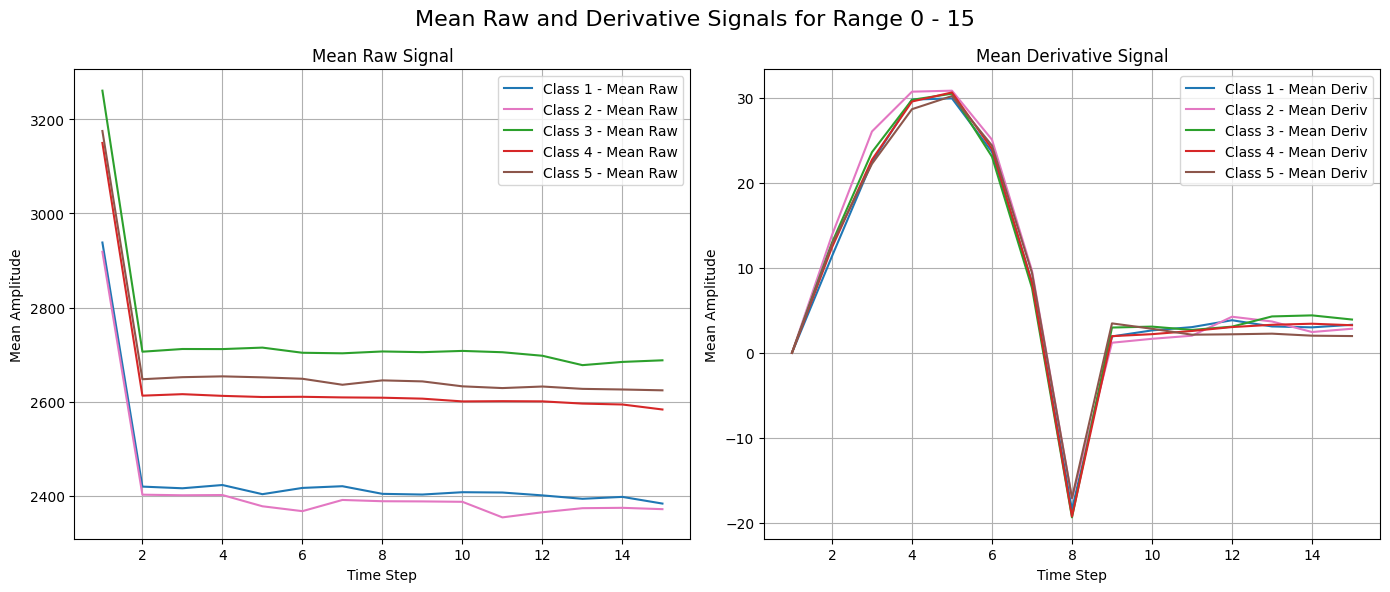

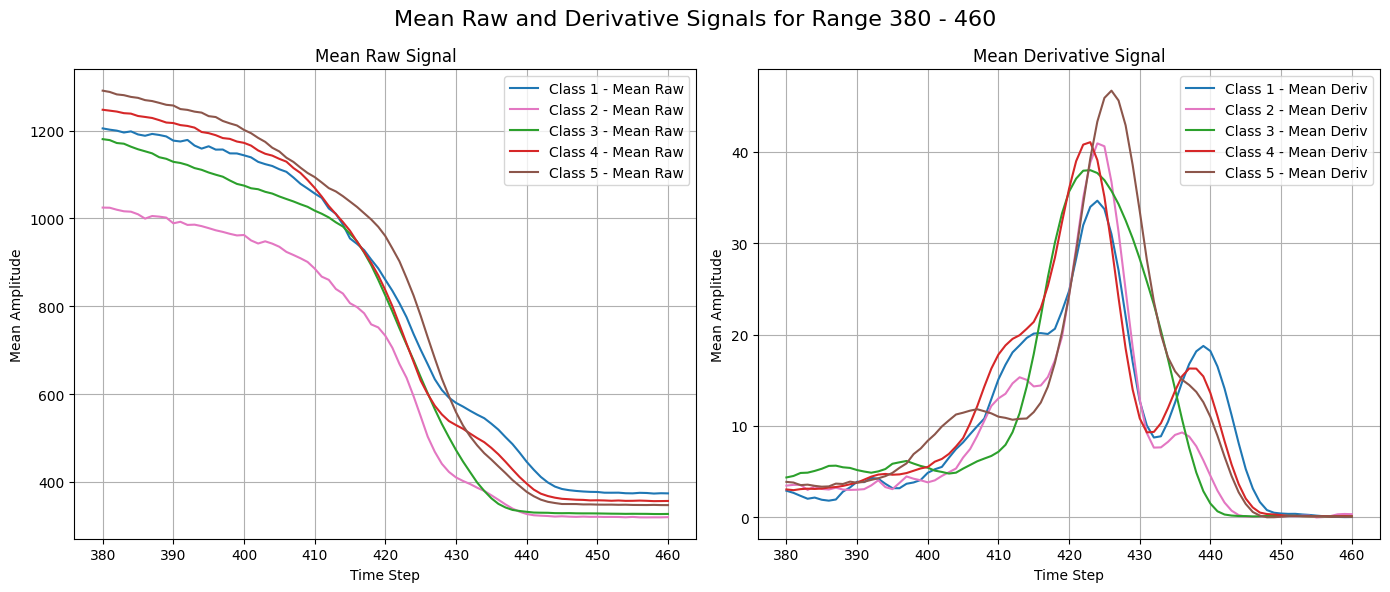

In [277]:
# Inspecting the zoomed-in view of the signals
zoom_ranges = [(0, 15), (380, 460)]

for start, end in zoom_ranges:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(f"Mean Raw and Derivative Signals for Range {start} - {end}", fontsize=16)
    axes[0].set_title("Mean Raw Signal")
    axes[1].set_title("Mean Derivative Signal")

    for class_idx, df in enumerate(dataframes):
        cols_in_range = [col for col in df.columns if start <= int(col) <= end]

        signal_raw_indices = df.index[df.index.str.contains('signal_raw')].tolist()
        signal_deriv_indices = df.index[df.index.str.contains('signal_deriv')].tolist()

        if signal_raw_indices:
            mean_raw = df.loc[signal_raw_indices, cols_in_range].mean(axis=0)
            axes[0].plot(mean_raw, label=f'Class {class_idx+1} - Mean Raw', linestyle='-', color=colors[class_idx])
            axes[0].set_xlabel("Time Step")
            axes[0].set_ylabel("Mean Amplitude")
            axes[0].legend()
            axes[0].grid(True)

        if signal_deriv_indices:
            mean_deriv = df.loc[signal_deriv_indices, cols_in_range].mean(axis=0)
            axes[1].plot(mean_deriv, label=f'Class {class_idx+1} - Mean Deriv', linestyle='-', color=colors[class_idx])
            axes[1].set_xlabel("Time Step")
            axes[1].set_ylabel("Mean Amplitude")
            axes[1].legend()
            axes[1].grid(True)

    plt.tight_layout()
    plt.show()

#### Not much noticeable difference in the time range 0-15, apart from minor amplitude variation, which persists across all the time steps. Hence, this ranges doesn't offer much discriminative informaiton. However, in the range 380-460, two peaks can be observed and the peaks differ noticelby in amplitude across classes. Let's focus on this time window for the feature extraction and statistical analysis.


### 3) Feature Extraction and Statistical Analysis


In [278]:
# Extract per sample features from the signals for each class for the (380, 460) time window
# This includes peak amplitude, peak location, mean amplitude, area under curve (AUC),

# # time window of interest
start, end = 380, 460

features_list = []
for class_idx, df in enumerate(dataframes):
    
    raw_indices = [idx for idx in df.index if 'signal_raw' in idx]
    deriv_indices = [idx for idx in df.index if 'signal_deriv' in idx]

    # Extract features for signal_raw
    for idx in raw_indices:
        cols_in_window = [col for col in df.columns if start <= int(col) <= end]
        window_values = df.loc[idx, cols_in_window].astype(float).values

        # Features
        peak_amp = window_values.max()
        peak_loc = window_values.argmax() + start   # convert idx to actual time step
        mean_amp = window_values.mean()
        auc = np.trapz(window_values)  # area under curve
        std_amp = window_values.std()

        features_list.append({
            'class': class_idx + 1,
            'class_name': class_names[class_idx],
            'sample_id': idx,
            'signal_type': 'signal_raw',
            'peak_amplitude': peak_amp,
            'peak_location': peak_loc,
            'mean_amplitude': mean_amp,
            'auc': auc,
            'std_amplitude': std_amp
        })

    # Extract features for signal_deriv
    for idx in deriv_indices:
        cols_in_window = [col for col in df.columns if start <= int(col) <= end]
        window_values = df.loc[idx, cols_in_window].astype(float).values

        peak_amp = window_values.max()
        peak_loc = window_values.argmax() + start
        mean_amp = window_values.mean()
        auc = np.trapz(window_values)
        std_amp = window_values.std()

        features_list.append({
            'class': class_idx + 1,
            'class_name': class_names[class_idx],
            'sample_id': idx,
            'signal_type': 'signal_deriv',
            'peak_amplitude': peak_amp,
            'peak_location': peak_loc,
            'mean_amplitude': mean_amp,
            'auc': auc,
            'std_amplitude': std_amp
        })

# Convert to DataFrame
features_df = pd.DataFrame(features_list)
features_df.head()

,class,class_name,sample_id,signal_type,peak_amplitude,peak_location,mean_amplitude,auc,std_amplitude
0,1,250328_E0ALTB_C10A_6e4_Classifiability-S-pneum...,signal_raw_tseries_Well_Id_10365,signal_raw,1404.0,380,908.975309,72724.0,392.153818
1,1,250328_E0ALTB_C10A_6e4_Classifiability-S-pneum...,signal_raw_tseries_Well_Id_9299,signal_raw,1463.0,380,1102.222222,88307.5,346.031505
2,1,250328_E0ALTB_C10A_6e4_Classifiability-S-pneum...,signal_raw_tseries_Well_Id_7137,signal_raw,1690.0,380,1069.913580,85602.0,497.109005
3,1,250328_E0ALTB_C10A_6e4_Classifiability-S-pneum...,signal_raw_tseries_Well_Id_6477,signal_raw,1322.0,387,828.876543,66325.0,395.430360
4,1,250328_E0ALTB_C10A_6e4_Classifiability-S-pneum...,signal_raw_tseries_Well_Id_9990,signal_raw,448.0,392,396.839506,31749.5,37.534332


In [279]:
# Statistical analysis: ANOVA test to compare means across classes
'''
ANOVA, or Analysis of Variance, is a statistical method used to test whether three or more group means are significantly different from each other. It helps determine whether the variation in a dataset is 
due to actual differences between groups or just random noise.
'''

feature_names = ['peak_amplitude', 'peak_location', 'mean_amplitude', 'auc', 'std_amplitude']

for signal_type in ['signal_raw', 'signal_deriv']:
    print(f"\nStatistical Test Results for {signal_type}:\n")
    
    for feature in feature_names:
        # Prepare data groups by class
        groups = [features_df[(features_df['class'] == c) & (features_df['signal_type'] == signal_type)][feature].values for c in sorted(features_df['class'].unique())]

        # Run ANOVA
        f_stat, p_value = f_oneway(*groups)
        
        print(f"Feature: {feature:15} | F-statistic: {f_stat:.3f} | p-value: {p_value:.4e}")



Statistical Test Results for signal_raw:

Feature: peak_amplitude  | F-statistic: 24.561 | p-value: 1.2025e-19
Feature: peak_location   | F-statistic: 24.980 | p-value: 5.5993e-20
Feature: mean_amplitude  | F-statistic: 40.652 | p-value: 3.4270e-32
Feature: auc             | F-statistic: 40.774 | p-value: 2.7627e-32
Feature: std_amplitude   | F-statistic: 17.617 | p-value: 4.2041e-14

Statistical Test Results for signal_deriv:

Feature: peak_amplitude  | F-statistic: 37.641 | p-value: 7.0365e-30
Feature: peak_location   | F-statistic: 108.638 | p-value: 2.8672e-80
Feature: mean_amplitude  | F-statistic: 19.283 | p-value: 1.9388e-15
Feature: auc             | F-statistic: 19.351 | p-value: 1.7105e-15
Feature: std_amplitude   | F-statistic: 22.383 | p-value: 6.4778e-18


#### Since p-values for each feature for both signal_raw and signal_deriv is significantly less than 0.05 (5%), there is overwhelming evidence that at least one class has a different mean from the others for each test features. However, this doesn't tell us which classes' means are significantly differnet from each other making them distinguishable. We need to figure out where the difference lies.


In [280]:
# Tukey's HSD (Honest Significant Difference) test for post-hoc analysis
classes_idx = sorted(features_df['class'].unique()) # class labels
classes = {c: features_df[features_df['class'] == c]['class_name'].unique()[0] for c in classes_idx}

feature_names = ['peak_amplitude', 'peak_location', 'mean_amplitude', 'auc', 'std_amplitude']

for signal_type in ['signal_raw', 'signal_deriv']:
    print(f"\n--- Tukey HSD: {signal_type} ---\n")

    # Filter features for current signal type
    df_sub = features_df[features_df['signal_type'] == signal_type]

    # Loop over all class pairs
    for class1, class2 in combinations(classes_idx, 2):
        print(f"Class {class1} vs Class {class2}:")

        found_diff = False  # flag to check if any feature is significant

        for feature in feature_names:
            tukey = pairwise_tukeyhsd(endog=df_sub[feature], groups=df_sub['class'], alpha=0.05)
            
            # Convert summary to DataFrame for easier filtering
            summary_df = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])

            # Filter for current pair
            row = summary_df[((summary_df['group1'] == class1) & (summary_df['group2'] == class2)) | ((summary_df['group1'] == class2) & (summary_df['group2'] == class1))]

            if row['reject'].values[0]:  # if significant
                found_diff = True
                print(f"  - {feature:15} | mean diff: {row['meandiff'].values[0]:.4f} | p = {row['p-adj'].values[0]:.4e}")

        if not found_diff:
            print("  No significant feature differences.")
        print()


--- Tukey HSD: signal_raw ---

Class 1 vs Class 2:
  - peak_amplitude  | mean diff: -180.3456 | p = 0.0000e+00
  - peak_location   | mean diff: -0.9111 | p = 0.0000e+00
  - mean_amplitude  | mean diff: -141.5500 | p = 0.0000e+00
  - auc             | mean diff: -11348.3037 | p = 0.0000e+00
  - std_amplitude   | mean diff: -40.7734 | p = 2.9000e-03

Class 1 vs Class 3:
  - peak_location   | mean diff: -1.3262 | p = 0.0000e+00
  - mean_amplitude  | mean diff: -61.2372 | p = 0.0000e+00
  - auc             | mean diff: -4924.5553 | p = 0.0000e+00

Class 1 vs Class 4:
  - peak_location   | mean diff: -0.7351 | p = 0.0000e+00

Class 1 vs Class 5:
  - peak_amplitude  | mean diff: 84.6374 | p = 1.3800e-02
  - peak_location   | mean diff: -1.1031 | p = 0.0000e+00
  - std_amplitude   | mean diff: 48.6345 | p = 1.0000e-04

Class 2 vs Class 3:
  - peak_amplitude  | mean diff: 154.8672 | p = 0.0000e+00
  - peak_location   | mean diff: -0.4151 | p = 4.1700e-02
  - mean_amplitude  | mean diff: 80.31

In [281]:
classes

{1: '250328_E0ALTB_C10A_6e4_Classifiability-S-pneumoniae-2_0',
 2: '250331_E0AGDE_C18A_6e3_Classifiability-Linearity-Abaumannii-cplx-Apittii_0',
 3: '250331_E0A9Y6_C15B_6e4_Classifiability-Haemophilus-influenzae_0',
 4: '250328_E0ALTB_C10A_6e4_Classifiability-S-pneumoniae-2_0',
 5: '250328_E0ALTB_C10A_6e4_Classifiability-S-pneumoniae-2_0'}

#### Comparing the Tukey's HSD, for the raw signal, we can use almost all five features to somewhat distinguish between classes 1, 2, and 3, and some subsets of features to differentiate between other classes. For deriv signal, we can use almost all five features to somewhat disinguish between 2, 3, and 5, and some subsets of features to differentiate between other classes. Also, the distinguishability between classes 1, 4, and 5 is weak based on the above feature set. Since classes 1, 4, 5 have the same class name, either they are subclasses or replicates of the same ground truth.

| Signal Type    | Strongly Separable Classes | Weakly Separable Classes |
| -------------- | -------------------------- | ------------------------ |
| `signal_raw`   | Classes 1, 2, 3            | Classes 1 vs 4 vs 5      |
| `signal_deriv` | Classes 2, 3, 5            | Classes 1 vs 4 vs 5      |


### 4) Modeling



Random Forest Results for SIGNAL_RAW
Training samples: 1011, Testing samples: 338
Accuracy       : 0.4734
Weighted Precision: 0.4686
Weighted Recall   : 0.4734
Weighted F1 Score : 0.4670



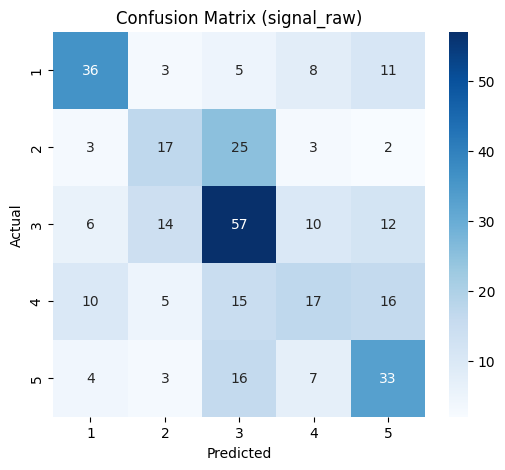

Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.57      0.59        63
           2       0.40      0.34      0.37        50
           3       0.48      0.58      0.53        99
           4       0.38      0.27      0.31        63
           5       0.45      0.52      0.48        63

    accuracy                           0.47       338
   macro avg       0.46      0.46      0.46       338
weighted avg       0.47      0.47      0.47       338


Random Forest Results for SIGNAL_DERIV
Training samples: 1011, Testing samples: 338
Accuracy       : 0.7959
Weighted Precision: 0.7943
Weighted Recall   : 0.7959
Weighted F1 Score : 0.7930



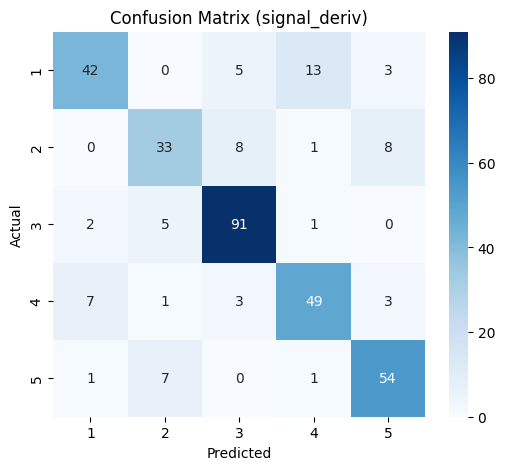

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.67      0.73        63
           2       0.72      0.66      0.69        50
           3       0.85      0.92      0.88        99
           4       0.75      0.78      0.77        63
           5       0.79      0.86      0.82        63

    accuracy                           0.80       338
   macro avg       0.78      0.78      0.78       338
weighted avg       0.79      0.80      0.79       338



In [282]:
# check the classifiablity of the features using supervised classification

# Features to use
feature_names = ['peak_amplitude', 'peak_location', 'mean_amplitude', 'auc', 'std_amplitude']
models = {}  # Store models for each signal type

# Loop for both signal types
for signal_type in ['signal_raw', 'signal_deriv']:
    print(f"\n{'='*40}")
    print(f"Random Forest Results for {signal_type.upper()}")
    print(f"{'='*40}")

    # Filter features for the given signal type
    df_sub = features_df[features_df['signal_type'] == signal_type]

    # Define features and target
    X = df_sub[feature_names].values
    y = df_sub['class'].values

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
    print(f"Training samples: {len(X_train)}, Testing samples: {len(X_test)}")

    # Train Random Forest
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train, y_train)
    models[signal_type] = clf

    # Predict and evaluate
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy       : {acc:.4f}")
    print(f"Weighted Precision: {prec:.4f}")
    print(f"Weighted Recall   : {rec:.4f}") 
    print(f"Weighted F1 Score : {f1:.4f}\n")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=sorted(df_sub['class'].unique()),
                yticklabels=sorted(df_sub['class'].unique()))
    plt.title(f'Confusion Matrix ({signal_type})')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    print("Classification Report:")
    print(classification_report(y_test, y_pred))


#### Intepretation of Above Results from Random Forest

signal_raw

- Accuracy and recall are around 47%, which is quite low. This means your model is struggling to correctly identify samples and raw signal features alone don’t separate classes well.

signal_deriv

- Much better results here: accuracy and recall near 80%.
- Recall is above 65% for all classes, with class 3 close to 92% recall. The model struggles with predicting classes 1 and 2 based on this feature set.
- This shows derivative features in the chosen time frame (380-460) are much more discriminative, likely capturing subtle differences in signal changes.
- Classes are generally being identified with good sensitivity.

Key Takeaway: Derivative features are stronger predictors of the classes than raw signals.


peak_amplitude: 0.2861
peak_location: 0.1694
mean_amplitude: 0.1667
auc: 0.1701
std_amplitude: 0.2077


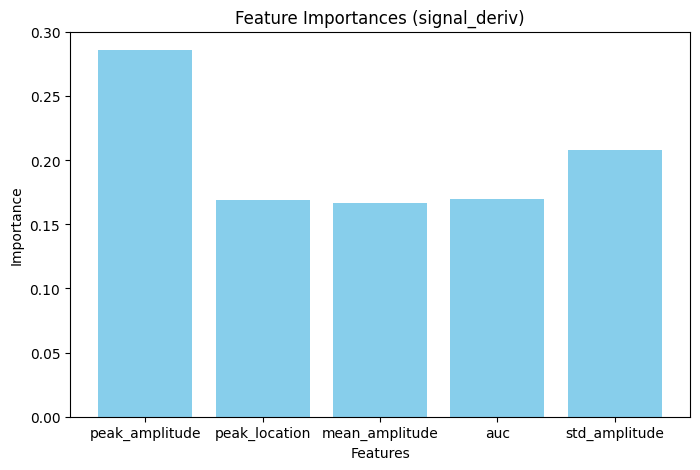

In [283]:
# post training analysis

# 1) Feature importance analysis

clf_deriv = models['signal_deriv']

importances = clf_deriv.feature_importances_
for fname, importance in zip(feature_names, importances):
    print(f"{fname}: {importance:.4f}")

# Optional: plot feature importances
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(feature_names, importances, color='skyblue')
plt.title(f'Feature Importances ({signal_type})')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.show()


#### All 5 features contribute nearly equal and thus important


### 5) Summary and Conclusion

- _Approach & Justification:_ Combination of visual, statistical, and ML methods provides a multi-angle assessment of class separability.

- _Separation of classes:_ The five classes show some overlap in raw signals but better separation in derivative signals, confirmed by classification recall. Based on the derivative signals with the above 5 feature set, the classes are significantly distinguishable as we get a recall of 79%.

- _Consistent patterns:_ Differences in amplitude and peak characteristics, especially in derivative signals between the time window towards the end.

- _Limitation:_

  - _Visual overlap obscures subtle differences_: For the above data, signal plots across classes were visually similar, making it difficult to detect meaning distinctions (even in the selected time from of 380-460) without quantitative analysis. Visual exploratory analysis is necessary to get an idea about the shape and trend of the signals but not sufficien to render classifiability decisions solely based on it.

  - _Descriptive statistics ignored feature interactions_: We used summary metrics like mean, standard deivation and peak amplitude as our features, however, treating them independently may miss complex features that only emerge when features are combined. The use of a Random Forest significantly improved classification, which confirms interaction between the feature matters.

  - _Descriptinve Analysis doesn't guarantee classifiability_: Even thon statistical analysis like ANOVA/Tukey showed statistically significatn differences in feature means, classfication on raw signals features performed poorly (recall ~47%). This shows that just because classes differ statistically doesn't means those differences are strong or consistent enough to allow a model to reliably seprate them.
